This is a notebook that shows a barebone construction of the AlexNet2 network. AlexNet2 is the one that Alex Krizhevsky used in his "One weird trick" paper. The difference between AlexNet2 and AlexNet is that there is no group convolution, making the overall architecture simpler.

This notebook is not intended to train a full model at its maximum accuracy. Instead, we just want to show how one can design the multiple parts of the algorithm in Python, and directly run the training procedure in Python.

In [1]:
%matplotlib inline
from matplotlib import pyplot
import math
import numpy as np
from pycaffe2 import core, core_gradients, workspace, visualize

loaded nvd3 IPython extension
run nvd3.IPython_wrapper.initialize_javascript() to set up the notebook
help(nvd3.IPython_wrapper.initialize_javascript) for options


Now, for problems as large as ImageNet, it is often the case that a lot of things run for very long, and we probably also want to inspect the progress of the code. As a result, we set a folder together with the workspace, and also run mint - a very thin visual inspector that would allow us to look at the progress of the training.

In [2]:
ROOT_FOLDER = '/tmp/caffe_workspace'
workspace.ResetWorkspace('/tmp/caffe_workspace')
workspace.InitGoogleLogging()

True

Let's write up the network together with the SGD training. As you can see, it is unified into one single network, without any external solver needed. You will need to change the db path to the db file you actually have on your disk.

In [3]:
init_net = core.Net("init")

# constant values used in the optimization procedure.
MOMENTUM = init_net.ConstantFill([], "MOMENTUM", shape=[1], value=0.9)
WEIGHT_DECAY = init_net.ConstantFill([], "DECAY", shape=[1], value=0.0005)
ONE = init_net.ConstantFill([], "ONE", shape=[1], value=1.0)
# Let's use caffe's old storage order (NCHW). Note that you can use NHWC as the
# order as well - just make sure you initialize the parameters with the right
# shape as well.
order = "NCHW"
train_net = core.Net("train")

# First, we get the image input, and obtain the data and label.
# If you would like to use the old good caffe training data format in Datum protobuffer,
# make sure you set use_caffe_datum=True.
data, label = train_net.ImageInput(
    [], ["data", "label"], batch_size=128,
    #db="/y/jiayq/caffe2-train-leveldb/", db_type='leveldb',
    db="/x/caffe-train-lmdb/", db_type='lmdb', use_caffe_datum=True,
    mean=128., std=128., scale=256, crop=227, mirror=1)
if order == "NCHW":
    data = data.NHWC2NCHW([], 'data_nchw')

# Second, we get the model designed. Note that the Fills are placed in the init_net part,
# and the actual computation are in the train_net part.

# Conv1 and pool1
filter1 = init_net.GaussianFill([], "filter1", shape=[64, 3, 11, 11], std=math.sqrt(2./11/11/3))
bias1 = init_net.ConstantFill([], "bias1", shape=[64,], value=0.0)
pool1 = (data.Conv([filter1, bias1], ['conv1'], kernel=11, pad=0, stride=4, order=order)
             .Relu([], ['relu1'])
             .LRN(outputs=2, size=5, alpha=0.0001, beta=0.75, order=order)[0]
             .MaxPool([], 'pool1', kernel=3, stride=2, order=order))
# Conv2 and pool2
filter2 = init_net.GaussianFill([], "filter2", shape=[192, 64, 5, 5], std=math.sqrt(2./5/5/64))
bias2 = init_net.ConstantFill([], "bias2", shape=[192,], value=0.0)
pool2 = (pool1.Conv([filter2, bias2], ['conv2'], kernel=5, pad=2, order=order)
              .Relu()
              .LRN(outputs=2,size=5, alpha=0.0001, beta=0.75, order=order)[0]
              .MaxPool([], "pool2", kernel=3, stride=2, order=order))
# Conv3, conv4
filter3 = init_net.GaussianFill([], "filter3", shape=[384, 192, 3, 3], std=math.sqrt(2./192/3/3))
bias3 = init_net.ConstantFill([], "bias3", shape=[384,], value=0.0)
conv3 = pool2.Conv([filter3, bias3], ['conv3'], kernel=3, pad=1, order=order).Relu()
filter4 = init_net.GaussianFill([], "filter4", shape=[384, 384, 3, 3], std=math.sqrt(2./384/3/3))
bias4 = init_net.ConstantFill([], "bias4", shape=[384,], value=0.0)
conv4 = conv3.Conv([filter4, bias4], ['conv4'], kernel=3, pad=1, order=order).Relu()
# Conv5, pool5
filter5 = init_net.GaussianFill([], "filter5", shape=[256, 384, 3, 3], std=math.sqrt(2./384/3/3))
bias5 = init_net.ConstantFill([], "bias5", shape=[256,], value=0.0)
conv5 = conv4.Conv([filter5, bias5], ['conv5'], kernel=3, pad=1, order=order)
pool5_flatten = (conv5.MaxPool([], "pool5", kernel=3, stride=2, order=order)[0]
                      .Relu().Flatten())
# FC6, FC8, FC8, and softmax
W6 = init_net.GaussianFill([], "W6", shape=[4096, 6 * 6 * 256], std=0.005)
B6 = init_net.ConstantFill([], "B6", shape=[4096], value=0.0)
W7 = init_net.GaussianFill([], "W7", shape=[4096, 4096], std=0.005)
B7 = init_net.ConstantFill([], "B7", shape=[4096], value=0.0)
W8 = init_net.GaussianFill([], "W8", shape=[1000, 4096], std=0.01)
B8 = init_net.ConstantFill([], "B8", shape=[1000], value=0.)
pred = (pool5_flatten.FC([W6, B6], "fc6").Relu().Dropout(outputs=2)[0]
                   .FC([W7, B7], "fc7").Relu().Dropout(outputs=2)[0]
                   .FC([W8, B8], "fc8").Softmax())
# Cross entropy with label.
xent = pred.LabelCrossEntropy([label], "xent")
# The loss function.
loss, xent_grad = xent.AveragedLoss([], ["loss", xent.Grad()])
train_net.AddGradientOperators(skip=2)

# Blobs controlling the iteration.
ITER = train_net.Iter([], 'iter')
# There is one interesting thing here: since we are minimizing, we are
# doing "descent" so the learning rate is set to be negative.
LR = train_net.LearningRate(
    [ITER], "LR", base_lr=-0.01, policy="step", stepsize=10000, gamma=0.9)

# Now, in the old Caffe code, we have a Solver object that does all SGD
# specific updates. Since now we just have operators, solver is nothing
# but a bunch of new operators. Here we show how we implement the momentum
# SGD with weight decays.
all_params = [filter1, bias1, filter2, bias2, filter3, bias3, filter4, bias4, filter5, bias5,
              W6, B6, W7, B7, W8, B8]
# (1) Add weight decay for the weight terms. Bias do not get weight decay.
for param in [filter1, filter2, filter3, filter4, filter5, W6, W7, W8]:
    train_net.WeightedSum([param.Grad(), ONE, param, WEIGHT_DECAY], param.Grad())
# (2) do momentum and update.
for param in all_params:
    train_net.Accumulate([param.Grad()], str(param) + '_momentum', gamma=0.9)
    train_net.WeightedSum([param, ONE, str(param) + '_momentum', LR], param)    

# Now, all the computations are theoretically done. Let's do something
# fancy.
# These are optional: in terms of training, the summarizers do nothing.
# However, they will helps us to look at the progress of the training
# iterations.
# (1) Summarizes the parameters and their gradients, so we can inspect
#     their mean, std, min and max.
for param in [filter1, filter2, filter3, filter4, filter5, W6, W7, W8]:
    train_net.Summarize([param], [], to_file=1)
    train_net.Summarize([param.Grad()], [], to_file=1)
# (2) Summarize the intermediate blobs.
for blob in ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', "fc6", "fc7", "fc8"]:
    train_net.Summarize([blob], [], to_file=1)
# (3) We will also print the iteration, learning rate and loss to file.
train_net.PrintInt([ITER], [], to_file=1)
train_net.Print([LR, loss], [], to_file=1)
# (4) Snapshot the parameters after a few iterations.
train_net.Snapshot([ITER] + all_params,
                   db="/tmp/caffe_workspace/alexnet2_snapshot_%d",
                   db_type="minidb", every=1000)

# Now, we will tell the networks that we want to run on GPU.
init_net.RunAllOnGPU(gpu_id=0)
train_net.RunAllOnGPU(gpu_id=0)

# Since the network is essentially a DAG, we don't have to run everything
# sequentially: as long as the inputs of an operator are all ready, the operator
# can be executed. Thus, we set the training network to run in "dag" mode
# with 4 workers (threads). Note that this is different from mutli-GPU or
# multi-machine parallel: this parallelism is one the DAG topology level.
train_net.Proto().net_type = 'dag'
train_net.Proto().num_workers = 4

In [4]:
print init_net.Proto()

name: "init"
op {
  output: "MOMENTUM"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 1
  }
  arg {
    name: "value"
    f: 0.9
  }
}
op {
  output: "DECAY"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 1
  }
  arg {
    name: "value"
    f: 0.0005
  }
}
op {
  output: "ONE"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 1
  }
  arg {
    name: "value"
    f: 1.0
  }
}
op {
  output: "filter1"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 0.0742269619025
  }
  arg {
    name: "shape"
    ints: 64
    ints: 3
    ints: 11
    ints: 11
  }
}
op {
  output: "bias1"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 64
  }
  arg {
    name: "value"
    f: 0.0
  }
}
op {
  output: "filter2"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 0.0353553390593
  }
  arg {
    name: "shape"
    ints: 192
    ints: 64
    ints: 5
    ints: 5
  }
}
op {
  output: "bias2"
  nam

In [5]:
print train_net.Proto()

name: "train"
op {
  output: "data"
  output: "label"
  name: ""
  type: "ImageInput"
  arg {
    name: "std"
    f: 128.0
  }
  arg {
    name: "scale"
    i: 256
  }
  arg {
    name: "db_type"
    s: "leveldb"
  }
  arg {
    name: "db"
    s: "/y/jiayq/caffe2-train-leveldb/"
  }
  arg {
    name: "crop"
    i: 227
  }
  arg {
    name: "batch_size"
    i: 128
  }
  arg {
    name: "mirror"
    i: 1
  }
  arg {
    name: "mean"
    f: 128.0
  }
}
op {
  input: "data"
  output: "data_nchw"
  name: ""
  type: "NHWC2NCHW"
}
op {
  input: "data_nchw"
  input: "filter1"
  input: "bias1"
  output: "conv1"
  name: ""
  type: "Conv"
  arg {
    name: "kernel"
    i: 11
  }
  arg {
    name: "pad"
    i: 0
  }
  arg {
    name: "order"
    s: "NCHW"
  }
  arg {
    name: "stride"
    i: 4
  }
}
op {
  input: "conv1"
  output: "relu1"
  name: ""
  type: "Relu"
}
op {
  input: "relu1"
  output: "train_blob_0"
  output: "train_blob_1"
  name: ""
  type: "LRN"
  arg {
    name: "alpha"
    f: 0.

The workspace now has blobs:
['B6', 'B6_grad', 'B6_momentum', 'B7', 'B7_grad', 'B7_momentum', 'B8', 'B8_grad', 'B8_momentum', 'DECAY', 'LR', 'MOMENTUM', 'ONE', 'W6', 'W6_grad', 'W6_momentum', 'W7', 'W7_grad', 'W7_momentum', 'W8', 'W8_grad', 'W8_momentum', 'bias1', 'bias1_grad', 'bias1_momentum', 'bias2', 'bias2_grad', 'bias2_momentum', 'bias3', 'bias3_grad', 'bias3_momentum', 'bias4', 'bias4_grad', 'bias4_momentum', 'bias5', 'bias5_grad', 'bias5_momentum', 'conv1', 'conv1_grad', 'conv2', 'conv2_grad', 'conv3', 'conv3_grad', 'conv4', 'conv4_grad', 'conv5', 'conv5_grad', 'data', 'data_nchw', 'data_nchw_grad', 'fc6', 'fc6_grad', 'fc7', 'fc7_grad', 'fc8', 'fc8_grad', 'filter1', 'filter1_grad', 'filter1_momentum', 'filter2', 'filter2_grad', 'filter2_momentum', 'filter3', 'filter3_grad', 'filter3_momentum', 'filter4', 'filter4_grad', 'filter4_momentum', 'filter5', 'filter5_grad', 'filter5_momentum', 'iter', 'label', 'loss', 'pool1', 'pool1_grad', 'pool1_idx', 'pool2', 'pool2_grad', 'pool2_id

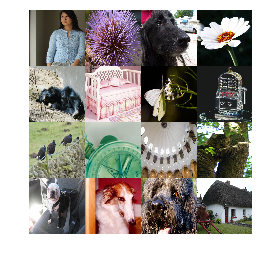

In [6]:
# After the networks are defined, we will run the networks.
# There are two ways to run a network:
# (1) call RunNetOnce() and directly pass in the network protobuffer. This will
#     create the network object on the fly, run it, and discard it directly.
#     This is useful when the network just needs to be run once (e.g. for
#     initialization).
# (2) create the network using CreateNet(), and then run it multiple times with
#     RunNet() by passing in the network name. If your network object contains
#     operators that has internal states (for example, an input layer that holds
#     a database), this is the right way to run the network.
# We will show such usage with init_net and train_net.

# Runs the initialization network.
workspace.RunNetOnce(init_net.Proto())
# Creates the training network.
workspace.CreateNet(train_net.Proto())

# Now, let's run the training network once, and see how the result look like.
workspace.RunNet('train')
print 'The workspace now has blobs:'
print workspace.Blobs()
print 'Let us show the data blob.'
images = workspace.FetchBlob('data')
# Let's move the values to [0, 1] for visualization.
normalized_images = (images - images.min()) / (images.max() - images.min())
# We will show 16 images. Also, since the images are in BGR order (yeah, OpenCV)
# we will need to change the order of the last dimension.
visualize.ShowMultiple(normalized_images[:16, :, :, ::-1])

print 'Loss value =', workspace.FetchBlob('loss')

Now, if you seriously want to run things for a couple days, you can do that too. Here we'll just run things for 20 iterations, recording the loss along the training procedure.

In [7]:
loss = np.zeros(2000)
for it in range(2000):
    workspace.RunNet('train')
    loss[it] = workspace.FetchBlob('loss')

Let's print out the loss.

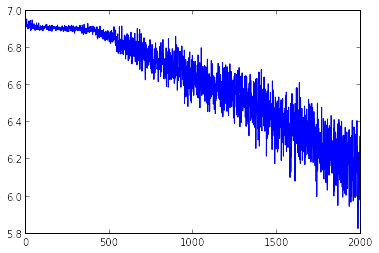

In [8]:
pyplot.plot(loss)

So, the above code all runs in Python - no C++ necessary, although the underlying model is actually running with the Caffe2 C++ code. Of course, you can train the model purely in C++ by creating a plan - see the MNIST example notebook on how to do that.